# Example of automated calculation of diffusion tensors with $\texttt{TAMMBER}$

## We pick a very simple system - vacancy diffusion in EAM-Fe for easy analysis

In [1]:
import numpy as np # log, exp, polyfit ....
import matplotlib.pyplot as plt # figures
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # to allow insets
from tqdm.notebook import tqdm # progress bars
from tammberAnalysis import DiffusionModel # our analysis module

## Load in $\texttt{TAMMBER}$ output after 15 minutes and 60 minutes on 280 cores

### This is to see the reduction in UQ with increased sampling for a simple model

In [2]:
print("After 15 minutes:")
cm_15min = DiffusionModel(state_file="MarkovModel_vacFe_15min.xml")
print("\n-------------------\nAfter 60 minutes:")
cm_60min = DiffusionModel(state_file="MarkovModel_vacFe_60min.xml")

After 15 minutes:

	Lattice Constant = 2.855200A

	Lattice Structure = bcc

	Primitive Unit Cell:
	 [-1.4276  1.4276  1.4276]

	 [ 1.4276 -1.4276  1.4276]

	 [ 1.4276  1.4276 -1.4276]

	SuperCell:
	 [19.9864  0.      0.    ] 
	 [ 0.     19.9864  0.    ] 
	 [ 0.      0.     19.9864]

	Center:
	 [9.9932 9.9932 9.9932] 


	Decompressed system has 1 states irredudible under translation

-------------------
After 60 minutes:

	Lattice Constant = 2.855200A

	Lattice Structure = bcc

	Primitive Unit Cell:
	 [-1.4276  1.4276  1.4276]

	 [ 1.4276 -1.4276  1.4276]

	 [ 1.4276  1.4276 -1.4276]

	SuperCell:
	 [19.9864  0.      0.    ] 
	 [ 0.     19.9864  0.    ] 
	 [ 0.      0.     19.9864]

	Center:
	 [9.9932 9.9932 9.9932] 


	Decompressed system has 1 states irredudible under translation


# Plotting Function

In [3]:
def plot_results(T,D_array,tau_array,runtime="15"):
    beta = 1.0/8.617e-5/T

    fig,axs = plt.subplots(1,1,dpi=120,figsize=(6,4))#,sharex=True)

    axs=[axs]

    axs.append(inset_axes(axs[0], width="100%", height="100%",bbox_to_anchor=(0.15,0.2,0.3,0.3),bbox_transform=axs[0].transAxes))

    axs[0].set_title(r"Vacancy in Fe, ${\tt{TAMMBER}}$ for %s minutes on 280 cores" % runtime)
    axs[0].set_ylabel(r"Diffusion constant [nm$^2$/$\mu$s]")
    
    # Formatting
    for ii in range(2):
        axs[ii].set_yscale("log")
        axs[ii].set_xlim(beta[-1],beta[0])
        axs[ii].set_xticks(beta[::2])
        axs[ii].set_xticklabels(["%d" % t for t in T[::2]])
        if ii>0:
            axs[ii].tick_params(axis="x",labelsize=8)
            axs[ii].tick_params(axis="y",labelsize=8)
            axs[ii].set_xlabel("Temperature [K]",fontsize=8)
    axs[0].set_xlabel("Temperature [K]")



    # Diffusion constants
    D = D_array * 1.0e4 # A^2 / ps -> nm^2 / us
    axs[0].plot(beta,D[:,0],lw=2,label=r"${\rm D}(\langle\tau\rangle)$=Trace[${\bf D}$]")
    axs[0].fill_between(beta,D[:,1],D[:,2],facecolor="C0",alpha=0.4,label=r"MC-UQ, N=%d" % Nsample)
    axs[0].plot(beta,D[:,3],'--',lw=2,label=r"${\rm D}({\langle\tau\rangle}),{\langle\tau\rangle\to\infty}$")

    # Arrhenius Fit
    p = np.polyfit(beta[:3],np.log(D[:3,0]),1)
    axs[0].text(beta[3],0.75*np.exp(p[0]*beta[0]+p[1]),r"$\Delta E=$%3.3geV" % -p[0])


    # tau inset
    tau = tau_array * 1.0e-6 # ps -> us
    axs[1].plot(beta,tau[:,0],lw=2,label=r"$\langle\tau\rangle$ [$\mu$s]")
    
    axs[1].set_ylim(0.5*tau[:,0].min(),2.0*tau[:,0].max())
    
    q = np.polyfit(beta[:3],np.log(tau[:3,0]),1)
    axs[1].text(beta[-3],0.75*np.exp(q[0]*beta[-2]+q[1]),r"$\Delta E=$%3.3geV" % -p[0],fontsize=8)

    for ii in range(2):
        axs[ii].legend(borderaxespad=.3,handletextpad=.5,ncol=1,\
                  handlelength=1.2,columnspacing=.5,labelspacing=0.5,borderpad=0.3,\
                       loc='upper %s' % ['right','left'][ii%2],fontsize=8+3*(ii==0))
    plt.show()

# D with UQ for a range of  temperatures for model output after 15 or 60 minutes

- Note the increase in the expected residence time $\langle\tau_{\rm res}\rangle$

- For this simple system the $\langle\tau_{\rm res}\rangle\to\infty$ limit is accurate even after a small amount of sampling

- For more complex systems this will not be the case- only the UQ bounds can be trusted

- Main difference in predicted diffusivity is due to Bayesian update of prefactor- this can be suppressed or removed by increasing `PrefactorCountThresh` in the input file or through Hessian calculation in `TASK_NEB`


	Full diffusion tensor in [nm^2/us] at T=700K:
	 [39.74 -0.   -0.  ]
	 [-0.   39.74 -0.  ]
	 [-0.   -0.   39.74]
	... which is isotropic to high precision


	Average residence time: 0.00121us



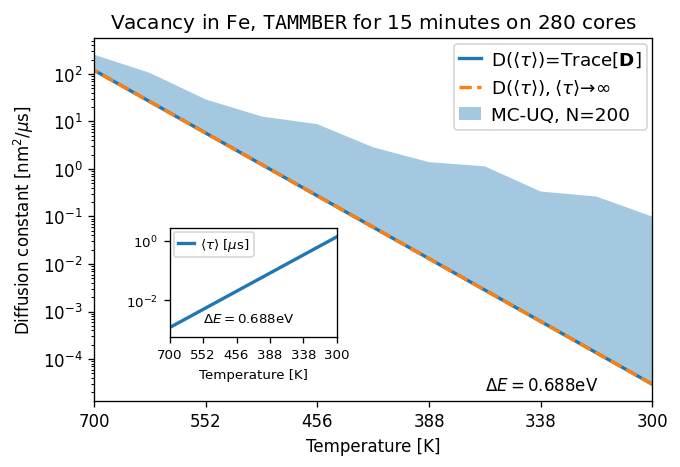


	Full diffusion tensor in [nm^2/us] at T=700K:
	 [68.03  0.    0.  ]
	 [ 0.   68.03  0.  ]
	 [ 0.    0.   68.03]
	... which is isotropic to high precision


	Average residence time: 0.0383us



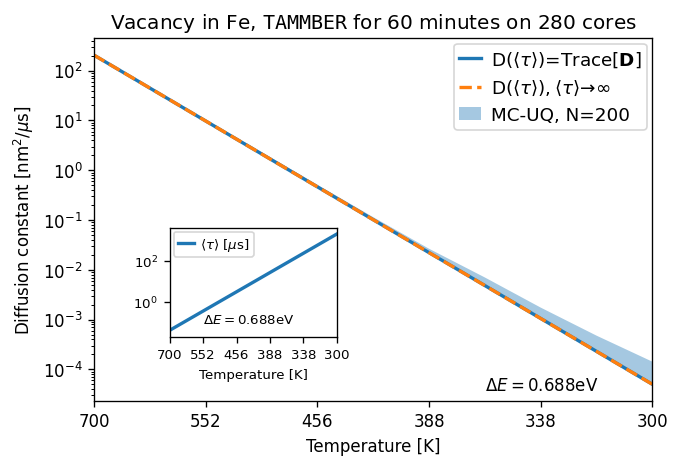

In [4]:
T = 1.0/np.linspace(1.0/300,1.0/700,11)
Nsample = 200 # small number for quick testing- ideally >100 for production

# We will take trace of the isotropic diffusion tensor

for ii,cm in enumerate([cm_15min,cm_60min]):
        
    print("\n\tFull diffusion tensor in [nm^2/us] at T=%dK:" % T[-1])
    D,tau = cm.calculateD(T[-1],ev=False)
    D *= 1.0e4 # A^2 / ps -> nm^2 / us
    for i in range(3):
        print("\t",np.round(D[i],2))
    if np.diag(D).std()/np.diag(D).max() < 1.0e-8:
        print("\t... which is isotropic to high precision\n")
    print("\n\tAverage residence time: %3.3gus\n" % (tau*1.0e-6))
    
    D_array = np.zeros((T.size,4)) # mean, max, min
    tau_array = np.zeros((T.size,3)) # mean, max, min

    pbar = tqdm(total=T.size,leave=True,desc="MC-UQ sampling")

    for i,_T in enumerate(T):
        # mmm = mean max min
        D_mmm,tau_array[i],D_vec = cm.sampleD(_T, Nsample = Nsample)
        D_array[i][:3] = D_mmm.sum(axis=1)
        D_array[i][3] = cm.calculateD(_T,pure=True)[0].sum()
        pbar.update(1)
    pbar.close()
    
    plot_results(T,D_array,tau_array,runtime=["15","60"][ii])

# Breakdown of diffusion tensor calculation from rates

We first calculate 

\begin{align}
    {\rm K}_{ij} &\equiv \sum_{l\in {i\leftarrow j}} {\rm k}_l\\
    %
    {\rm Kd}_{ij\alpha} &\equiv \sum_{l\in {i\leftarrow j}} {\rm k}_l\times[{\bf d}_l]_\alpha\\
    %
    {\rm Kdd}_{ij\alpha\beta} &\equiv \sum_{l\in {i\leftarrow j}} {\rm k}_l\times[{\bf d}_l\otimes{\bf d}_l]_{\alpha\beta}
    %
\end{align}
as well as the vector of estimated "unseen" transition rates $K_u$ and stationary distribution $\pi$.

We then calculate the diffusion tensor as described in the supplementary material. For this simple system there is no correlated contribution

In [5]:
evalT = 550.0

K,Kd,Kdd,Ku,pi = cm_60min.fill_rates(evalT)

Duc, Dc, tau = cm_60min.calcD(K,Kd,Kdd,Ku,pi) # Correlated (Dc) and uncorrelated (Duc) contributions
Duc *= 1.0e4 # A^2 / ps -> nm^2 / us
Dc *= 1.0e4 # A^2 / ps -> nm^2 / us


print("\n\tUncorrelated + Correlated = Full diffusion tensor in [nm^2/us] at T=%dK:\n" % evalT)

for i in range(3):
    for end,D in zip([" + "," = ","\n"],[Duc,Dc,Duc+Dc]):
        print("\t",np.round(D[i],4),end=end)
D = Duc+Dc
if np.diag(D).std()/np.diag(D).max() < 1.0e-8:
    print("\n\t... which is isotropic to high precision\n")
print("\n\tAverage residence time: %3.3gus\n" % (tau*1.0e-6))
    



	Uncorrelated + Correlated = Full diffusion tensor in [nm^2/us] at T=550K:

	 [ 3.03  0.   -0.  ] + 	 [0. 0. 0.] = 	 [ 3.03  0.   -0.  ]
	 [0.   3.03 0.  ] + 	 [0. 0. 0.] = 	 [0.   3.03 0.  ]
	 [-0.    0.    3.03] + 	 [0. 0. 0.] = 	 [-0.    0.    3.03]

	... which is isotropic to high precision


	Average residence time: 0.356us

